In [1]:
from pydrake.all import (MathematicalProgram, Solve, MonomialBasis,
                         DiagramBuilder, Evaluate, LogVectorOutput, Simulator,
                         SymbolicVectorSystem, Variable, ToLatex, Polynomial,
                         VectorSystem, eq, ge, le, Formula, Expression, Evaluate,
                         LeafSystem, AbstractValue,
                         )

from pydrake.all import (PiecewisePolynomial, ModelInstanceIndex,
    RotationMatrix, RigidTransform, Rgba, Box, Sphere, BaseField,
    Evaluate, Fields, PointCloud, MeshcatAnimation)

from IPython.display import clear_output

import os
import copy
import time
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from dataclasses import dataclass
import zarr

from dccm_quasistatic.utils.math_utils import (create_square_symmetric_matrix_from_lower_tri_array,
                                               get_n_lower_tri_from_matrix_dim,
                                               matrix_inverse)
from dccm_quasistatic.utils.sample_generator import (SampleGenerator, SampleGeneratorParams)
from dccm_quasistatic.controller.dccm_params import DCCMParams
from dccm_quasistatic.controller_synthesizer.dccm_synthesizer import DCCMSynthesizer
 
from qsim.parser import (
    QuasistaticParser,
    QuasistaticSystemBackend,
    GradientMode,
)

from qsim.simulator import ForwardDynamicsMode, InternalVisualizationType
from qsim.model_paths import models_dir, package_paths_dict

/home/shaoyuan/Documents/Software/quasistatic_simulator/robotics_utilities/qp_derivatives/qp_derivatives.py:2: DrakeDeprecationWarning: Please import from the pydrake.solvers module directly, instead of the deprecated pydrake.solvers.mathematicalprogram submodule. The deprecated code will be removed from Drake on or after 2023-05-01.
  import pydrake.solvers.mathematicalprogram as mp


In [2]:
from dccm_quasistatic.controller.dccm_controller_wo_inv import DCCMControllerWoInv


plt.rcParams.update({'font.size': 40})
linewidth = 5
def draw_plot(t, q, q_des, u, u_des, geodesic, tracking_error, openloop_tracking_error):
    clear_output(wait=True)
    fig, axs = plt.subplots(4, 1, figsize=(35, 40))

    axis = axs[0]
    axis.step(t, q, linestyle='solid', linewidth=linewidth)
    axis.step(t, q_des[:len(t)], linestyle='dashed', linewidth=linewidth)
    legend = axis.legend([r'$b_x$', r'$b_y$', r'$b_{\theta}$', r'$s_x$', r'$s_y$',
                 r'$b^*_x$', r'$b^*_y$', r'$b^*_{\theta}$', r'$s^*_x$', r'$s^*_y$'],
                 ncol=10, columnspacing=0.8,)
    axis.set_ylabel(r'$x$')

    axis = axs[1]
    axis.step(t, u, linestyle='solid', linewidth=linewidth)
    axis.step(t, u_des, linestyle='dashed', linewidth=linewidth)
    axis.legend([r'$u_{x}$',r'$u_{y}$', r'$u^*_{x}$',r'$u^*_{y}$'],
                ncol=4, columnspacing=0.8, loc='upper right')
    axis.set_ylabel(r'$u$')

    axis = axs[2]
    axis.step(t, geodesic, linewidth=linewidth)
    axis.set_ylabel('geodesic energy')

    axis = axs[3]
    axis.step(t, tracking_error, linewidth=linewidth)
    # axis.step(t, openloop_tracking_error, linewidth=linewidth)
    # axis.legend([r'DCCM',r'Open-loop'])
    axis.set_ylabel('tracking error')
    axis.set_xlabel('time(s)')
    plt.show()

def draw_comparison_plot(t, geodesics, tracking_errors, labels):
    fig, axs = plt.subplots(2, 1, figsize=(35, 20))

    axis = axs[0]
    for geodesic, label in zip(geodesics, labels):
        axis.step(t, geodesic, linewidth=linewidth, label=label)
    axis.set_ylabel('geodesic energy')
    axis.legend()

    axis = axs[1]
    for tracking_error, label in zip(tracking_errors, labels):
        axis.step(t, tracking_error, linewidth=linewidth, label=label)
    axis.legend()
    axis.set_ylabel('tracking error')
    axis.set_xlabel('time(s)')
    plt.show()

def get_results(sample_generator_params, dccm_params, traj_id):
    base_filename = f"samples{sample_generator_params.n_samples}_lbw{sample_generator_params.log_barrier_weight}_deg{dccm_params.deg}_beta{str(dccm_params.beta).split('.')[1]}.npy"
    results_file_name = f"results/circ_traj{traj_id}_ngeoseg_{dccm_params.n_geodesic_segments}_{base_filename}.zarr"
    root = zarr.open_group(results_file_name, mode='r')
    return root

def get_traj(traj_id):
    traj_file_name = f"desired_trajectories/{traj_id}.zarr"
    traj = zarr.open_group(traj_file_name, mode='r')
    return traj

def get_openloop_tracking_error(traj_id):
    traj = get_traj(traj_id)
    q_openloop = traj["q_openloop"][:]
    q_desired = traj["q_desired"][:]
    print(f"len q_openloop: {len(q_openloop)}")
    print(f"len q_desired: {len(q_desired)}")
    tracking_error = np.linalg.norm(q_openloop - q_desired, axis=1)[:100]
    return tracking_error

def get_openloop(traj_id):
    traj = get_traj(traj_id)
    return traj["q_openloop"][:]


total tracking error (500): 22.79396357683838
total tracking error (1000): 18.819328562874826
total tracking error (2000): 27.989334163795178
len geodesics: 3
len tracking_errors: 3


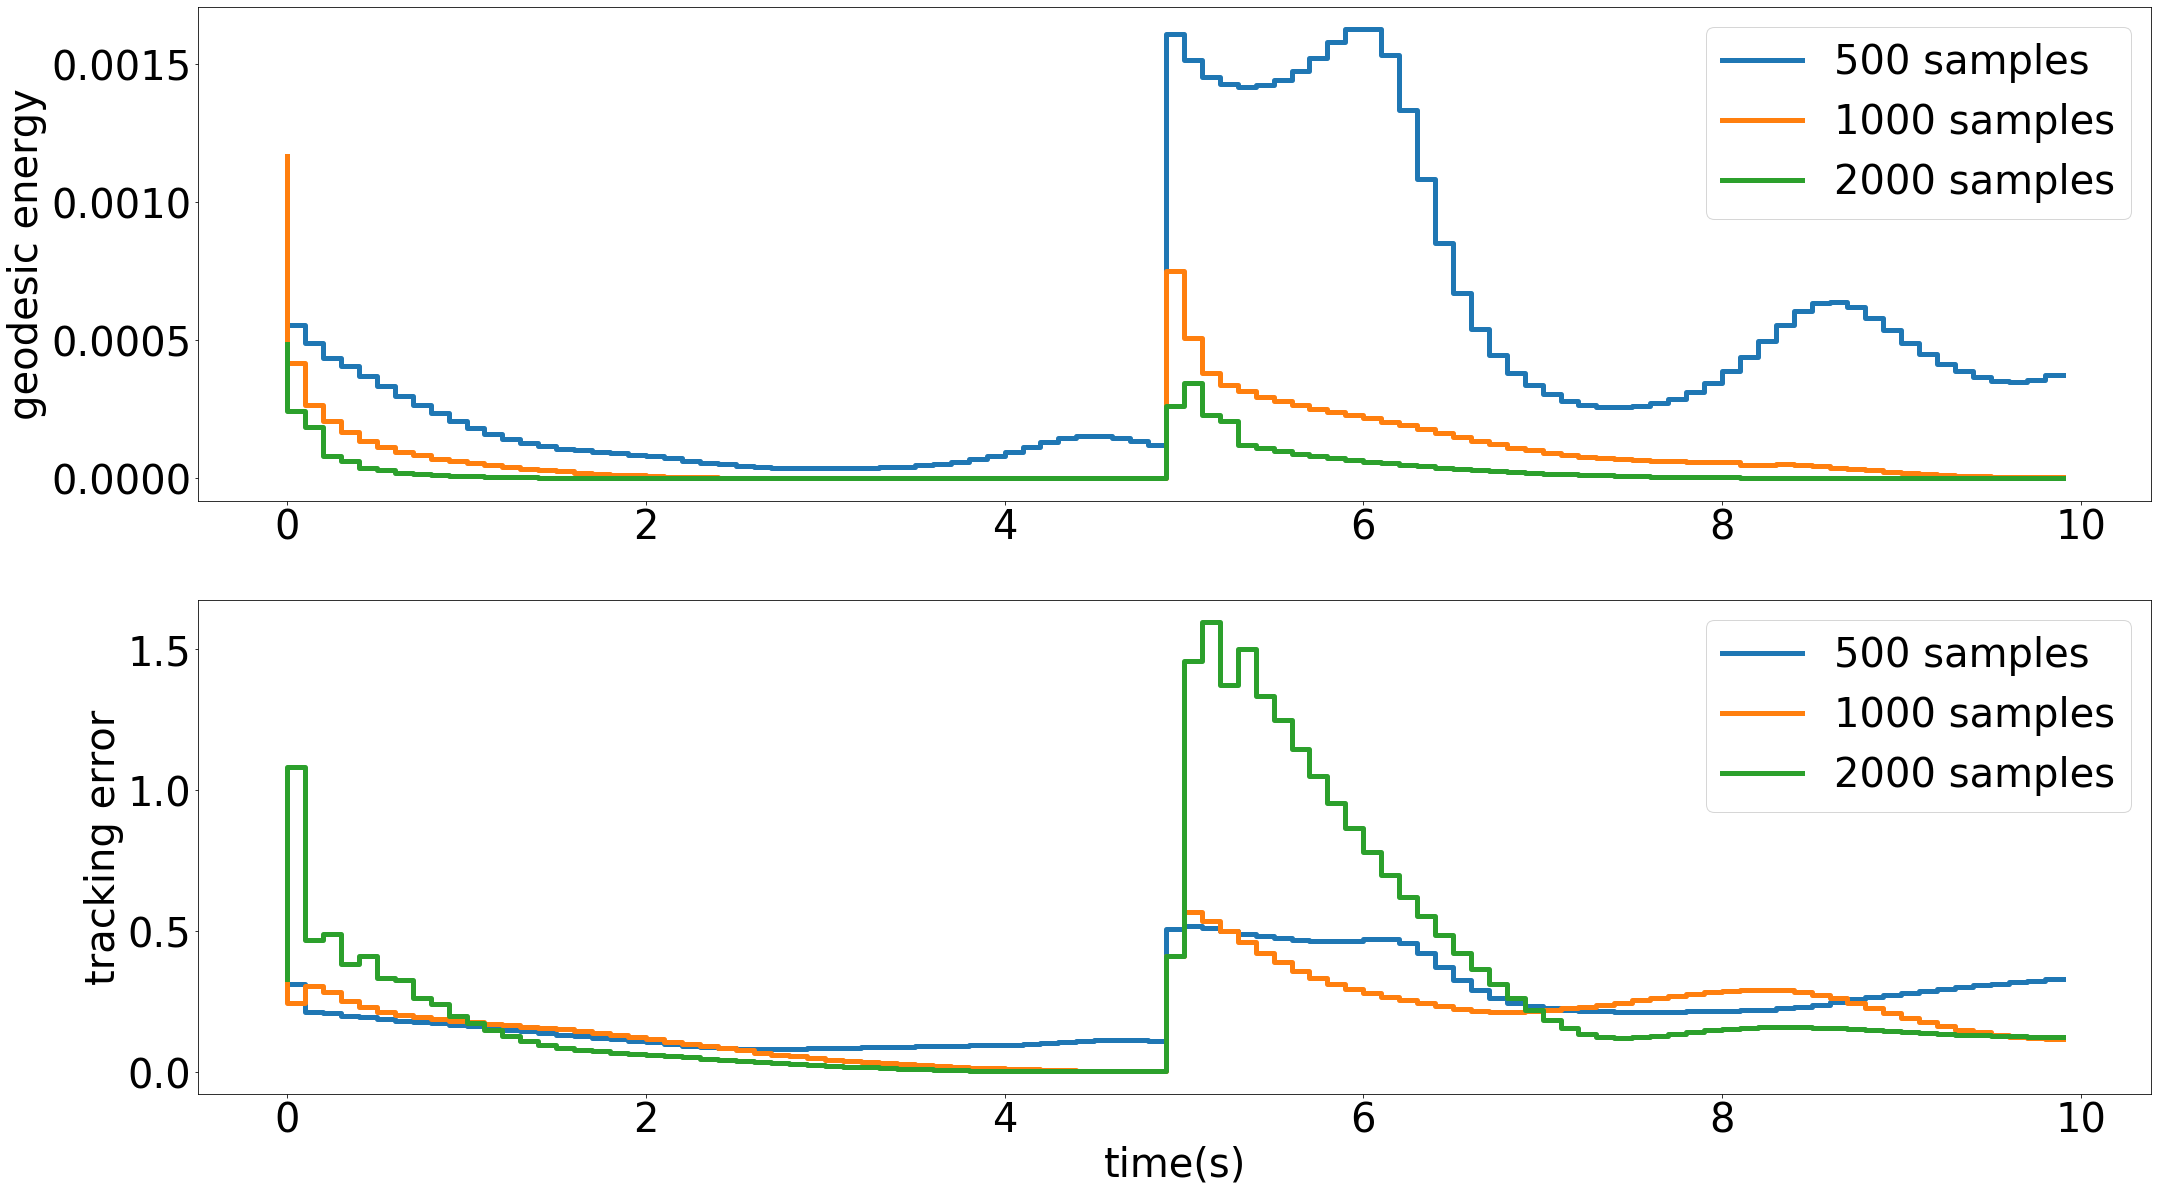

In [3]:
sample_generator_params = SampleGeneratorParams(
    log_barrier_weight=10,
    n_samples=500,
    actuated_collision_geomtery_names=["hand::collision"]
)

dccm_params = DCCMParams(
    dim_x=5,
    dim_u=2,
    deg=4,
    beta=0.1,
    n_geodesic_segments=1,
)

n_samples_list = [500, 1000, 2000]
geodesics = []
tracking_errors = []
labels = []
for n_samples in n_samples_list:
    sample_generator_params.n_samples = n_samples
    res = get_results(sample_generator_params, dccm_params, "A")
    geodesics.append(res["geodesic"][:])
    tracking_errors.append(res["tracking_error"][:])
    print(f"total tracking error ({n_samples}): {np.sum(res['tracking_error'][:])}")
    labels.append(f"{n_samples} samples")
t = res["t"][:]
print(f"len geodesics: {len(geodesics)}")
print(f"len tracking_errors: {len(tracking_errors)}")
draw_comparison_plot(t, geodesics, tracking_errors, labels)

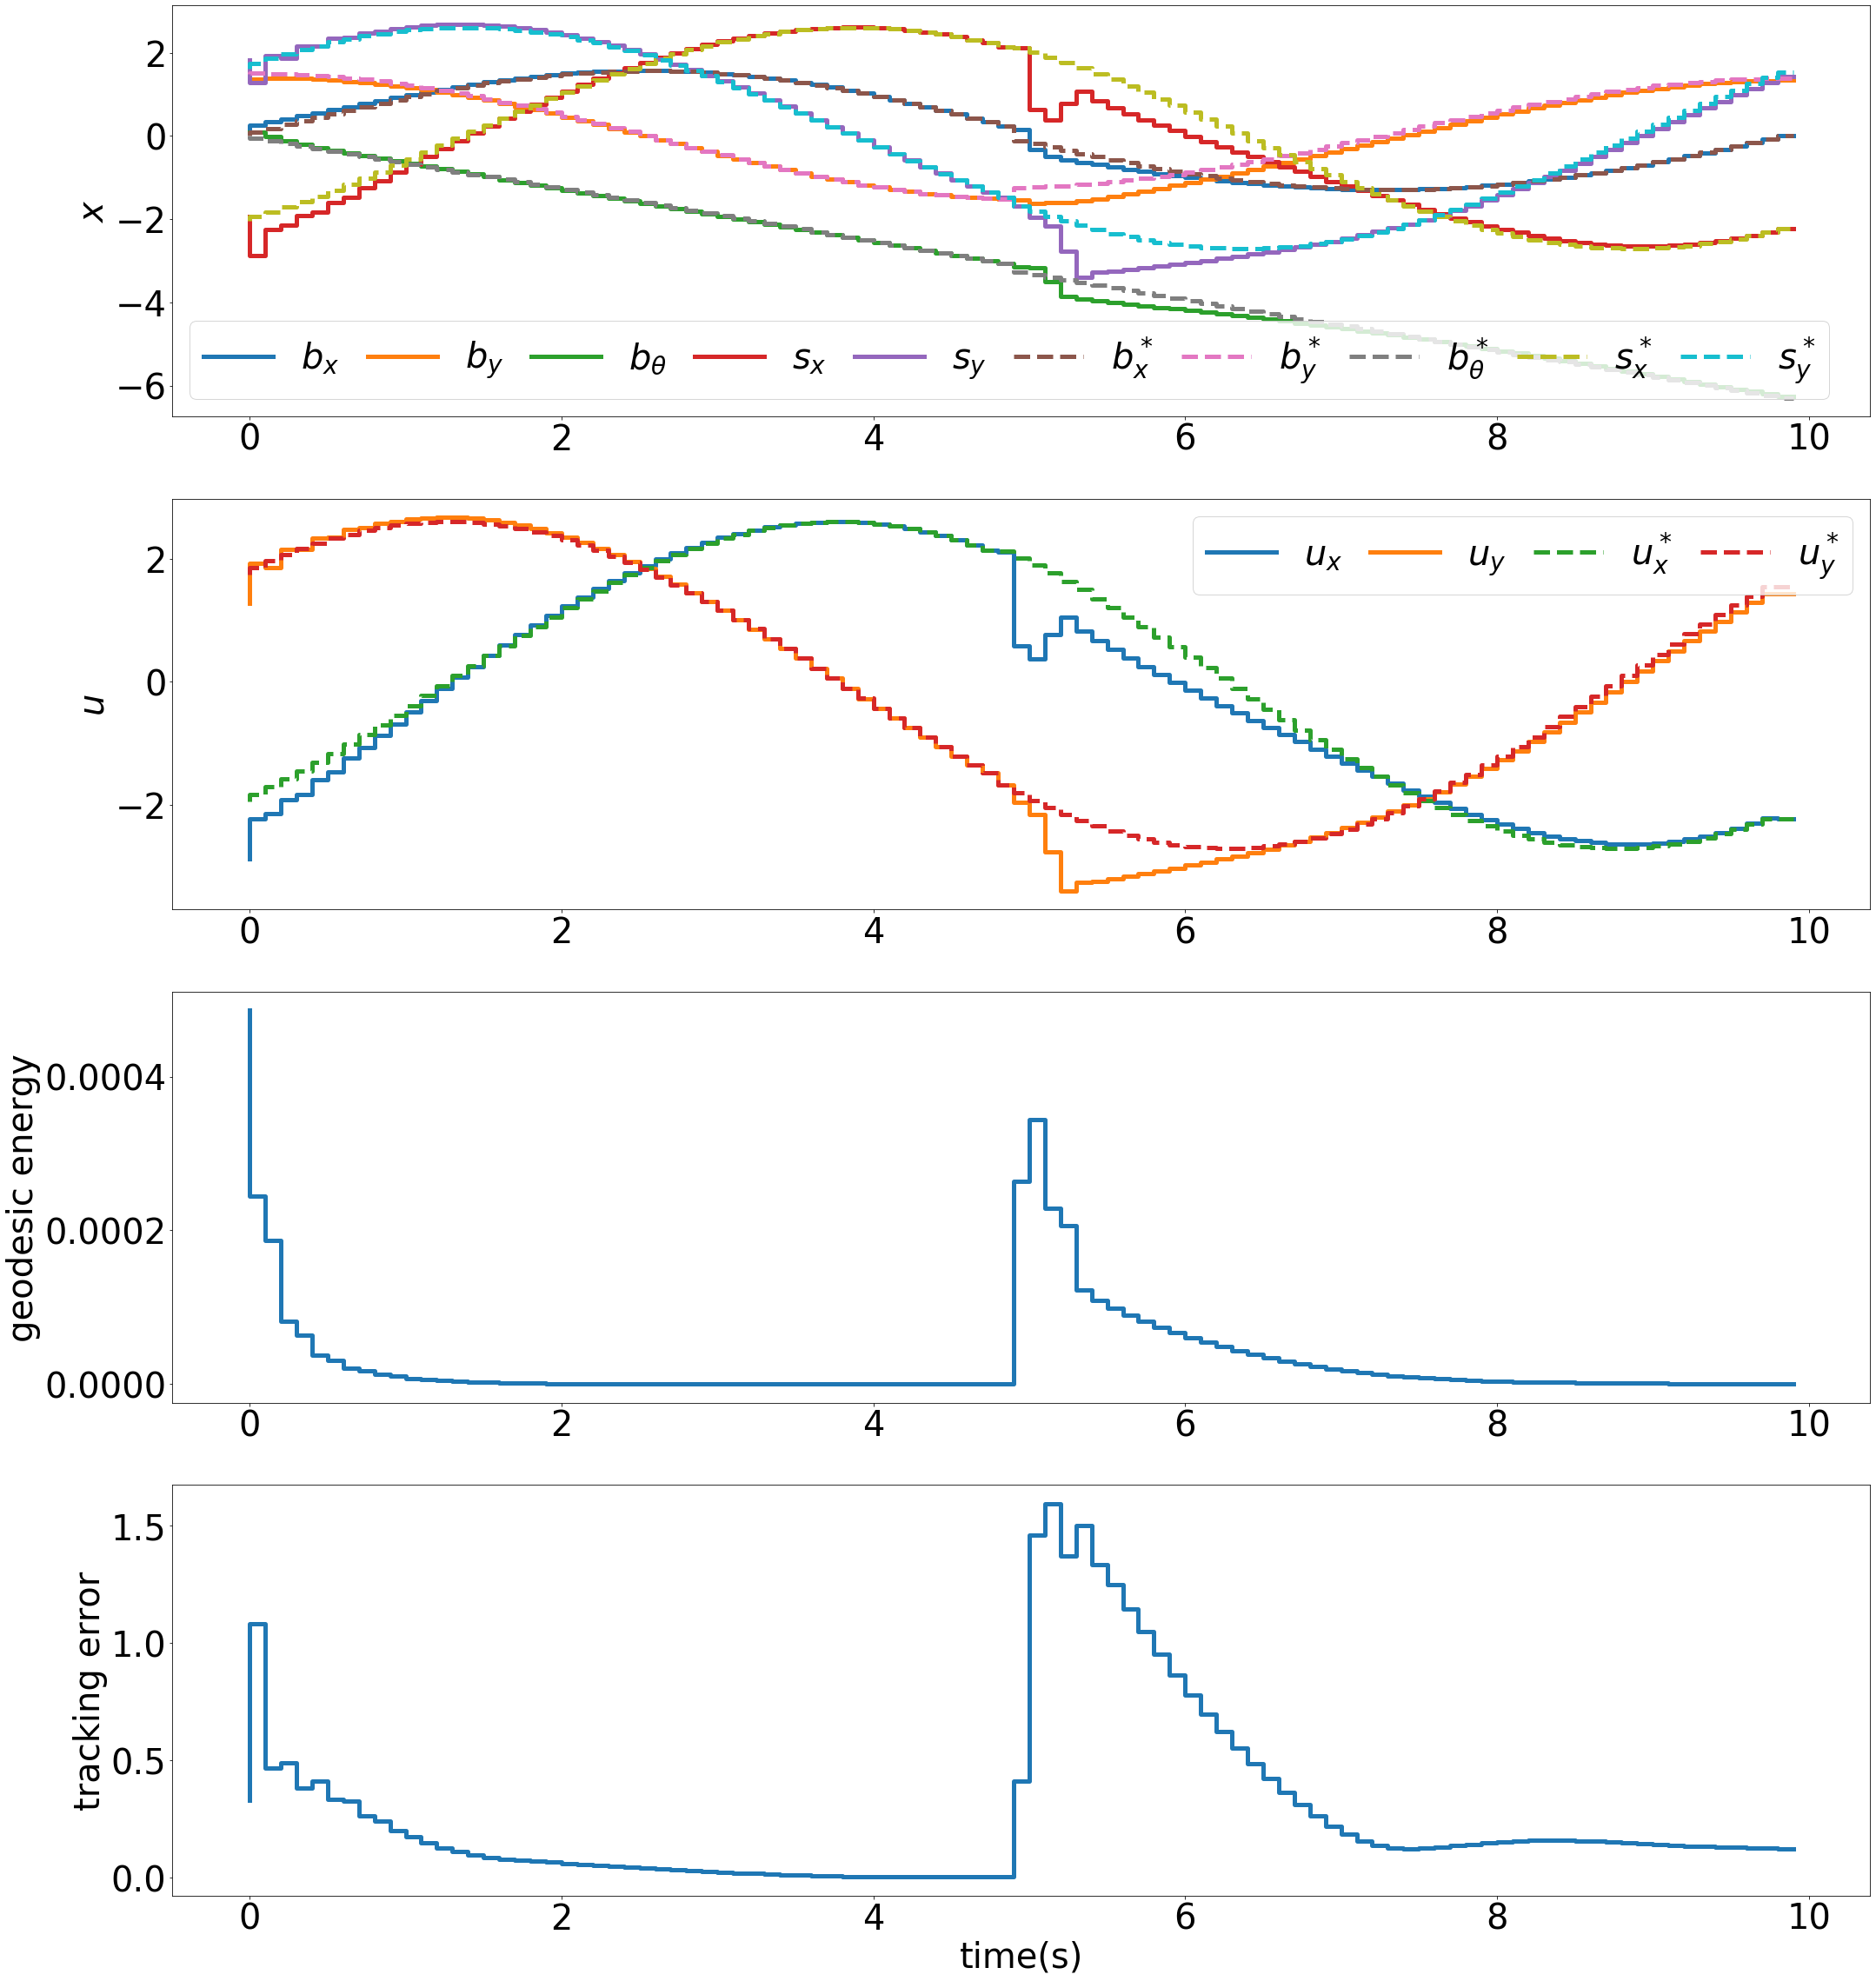

In [4]:
sample_generator_params = SampleGeneratorParams(
    log_barrier_weight=10,
    n_samples=2000,
    actuated_collision_geomtery_names=["hand::collision"]
)

dccm_params = DCCMParams(
    dim_x=5,
    dim_u=2,
    deg=4,
    beta=0.1,
    n_geodesic_segments=1,
)

best_res = get_results(sample_generator_params, dccm_params, "A")
openloop_tracking_error = get_openloop_tracking_error("A")
print(f"openloop_tracking_error: {len(openloop_tracking_error)}")
draw_plot(best_res["t"], best_res["q"], best_res["q_desired"], best_res["u"], best_res["u_desired"], best_res["geodesic"], best_res["tracking_error"], openloop_tracking_error)


# n_samples_list = [500] # already have the results for 2000
# for n_samples in n_samples_list:
#     sample_generator_params.n_samples = n_samples
#     evaluate_controller(sample_generator_params, dccm_params, "A")

# sample_generator_params.n_samples = 500
# dccm_params.deg = 4
# dccm_params.beta = 0.3


In [5]:
# sample_generator_params = SampleGeneratorParams(
#     log_barrier_weight=100,
#     n_samples=500,
#     actuated_collision_geomtery_names=["hand::collision"]
# )

# dccm_params = DCCMParams(
#     dim_x=5,
#     dim_u=2,
#     deg=6,
#     beta=0.1,
#     n_geodesic_segments=1,
# )

# evaluate_controller(sample_generator_params, dccm_params, "C")

In [6]:

import matplotlib.pyplot as plt
import numpy as np

def plot_states(t, states, labels, colors, linestyles):
    # Define the colors and markers for each set of states
    marker = 'o'

    # Define the box and sphere dimensions
    box_width = 1
    box_height = 1
    sphere_radius = 0.1

    # Define the figure and axis
    fig, ax = plt.subplots(figsize=(35, 20))

    # Loop through the time steps and plot the positions of the box and sphere
    for i in range(len(t)):
        for state, color, linestyle in zip(states[:, i], colors, linestyles):
            # Extract the positions and angles of the boxes
            box_x, box_y, box_theta = state[0], state[1], state[2]
            box_position = np.array([[box_x], [box_y]])

            # Compute the rotation matrix for the boxes
            R = np.array([[np.cos(box_theta), -np.sin(box_theta)], [np.sin(box_theta), np.cos(box_theta)]])

            # Define the corners of the box relative to its center
            box_corners = np.array([[-box_width/2, -box_height/2], [box_width/2, -box_height/2], [box_width/2, box_height/2], [-box_width/2, box_height/2], [-box_width/2, -box_height/2]])

            # Compute the absolute positions of the box corners
            absolute_box_corners = box_position.T + R.dot(box_corners.T).T

            # Extract the positions of the spheres
            sphere_x, sphere_y = state[3], state[4]

            # Plot the boxes and spheres
            ax.plot(absolute_box_corners[:, 0], absolute_box_corners[:, 1], color=color, linestyle=linestyle, linewidth=5)
            # Draw the circle
            # circle = plt.Circle((sphere_x, sphere_y), sphere_radius, fill=False, linewidth=5, color=color, linestyle=linestyle)
            # Add the circle to the axis
            # ax.add_artist(circle)

        # Add the time label to the center of the first box in the list
        ax.annotate(rf"$t={t[i]:.1f}$", xy=(states[0, i, :2]), ha='center', va='center', fontsize=30)

    # Add the legend
    for color, label in zip(colors, labels):
        ax.plot([], [], color=color, label=label, linewidth=2)
    ax.legend()

    ax.annotate(f"initial offset", xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center')
    ax.annotate(f"step change", xy=(0.5, 0.1), xycoords='axes fraction', ha='center', va='center')

    # Set the axis limits and labels
    v = 3
    h = 4
    ax.set_xlim(-h, h)
    ax.set_ylim(-v, v)
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_aspect('equal', adjustable='box')

    # Show the plot
    plt.show()

[None None None None None None]
[ 0 18 35 50 65 85]
desired states: [[ 0.          1.5        -0.         -2.03664997  1.61618592]
 [ 1.37324811  0.73063624 -1.10823254  0.59038157  2.53898099]
 [ 1.34005732 -0.81078919 -2.17382084  2.50942024  0.70605222]
 [-0.10954326 -1.23897704 -3.2742549   2.12313617 -1.67883926]
 [-1.10152555 -0.61760443 -4.20743268 -0.11027692 -2.70431939]
 [-0.99413522  0.89315717 -5.43343886 -2.60589223 -0.73101276]]
dccm states: [[ 0.2         1.4         0.1        -1.93664997  1.81618592]
 [ 1.39332479  0.70444477 -1.11424182  0.5942638   2.60575988]
 [ 1.34117819 -0.81182015 -2.17674613  2.52118822  0.71051708]
 [ 0.15033251 -1.53031191 -3.14604113  2.1253811  -1.6767173 ]
 [-1.15046165 -0.80756179 -4.36419848 -0.5040137  -2.83862011]
 [-0.99298408  0.8078695  -5.40359972 -2.51119119 -0.82227431]]
openloop states: [[ 0.2         1.4         0.1        -1.93664997  1.81618592]
 [ 1.4587258   0.6442893  -1.08688902  0.58572344  2.54650638]
 [ 1.48954723 -0.8

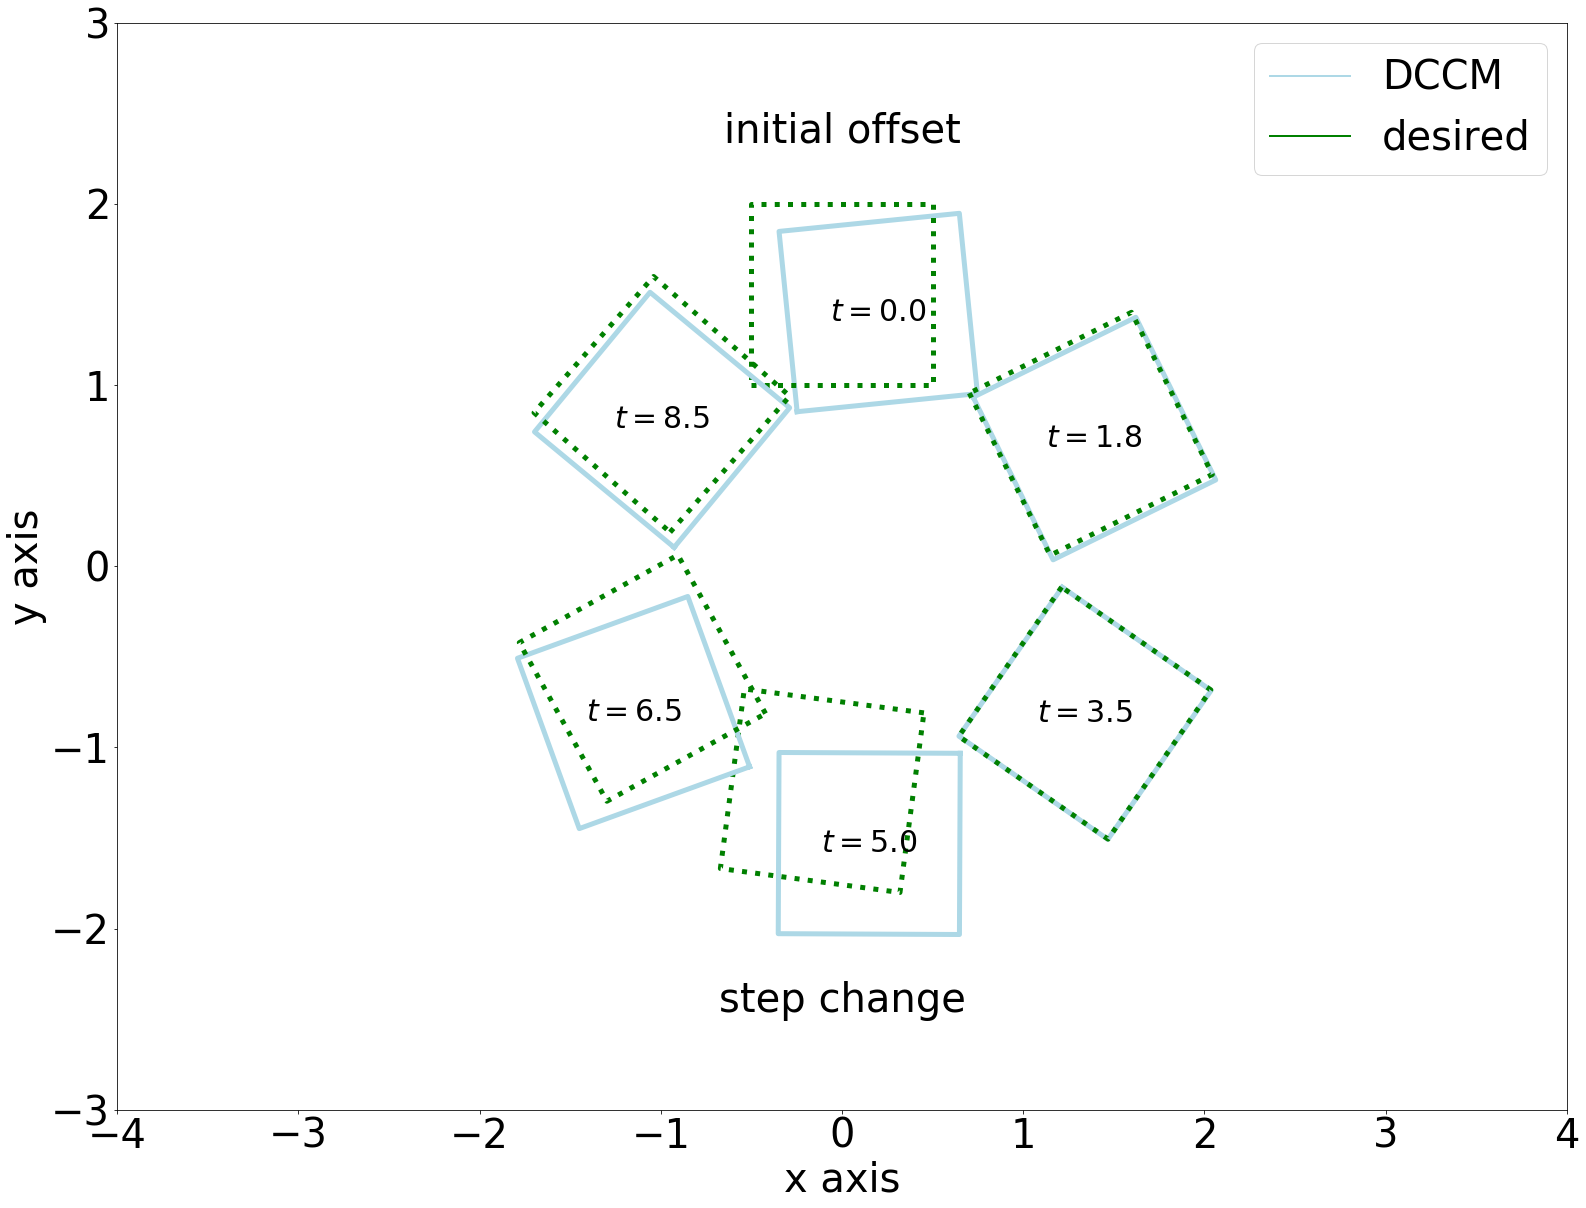

In [7]:
sample_generator_params = SampleGeneratorParams(
    log_barrier_weight=10,
    n_samples=2000,
    actuated_collision_geomtery_names=["hand::collision"]
)

dccm_params = DCCMParams(
    dim_x=5,
    dim_u=2,
    deg=4,
    beta=0.1,
    n_geodesic_segments=1,
)

best_res = get_results(sample_generator_params, dccm_params, "A")
# extract 5 evenly spaced states from the desired trajectory
# step = len(best_res["t"])//6
# cutoff = 100
# desired_states = best_res["q_desired"][:cutoff:step]
# dccm_states = best_res["q"][:cutoff:step]
# openloop_states = get_openloop("A")[:cutoff:step]
# t = best_res["t"][::step]

t = np.array([0, 1.8, 3.5, 5, 6.5, 8.5])
blank = np.array([None] * len(t))
print(blank)
t_indices = (t * 10).astype(int)
print(t_indices)
desired_states = best_res["q_desired"][:][t_indices]

dccm_states = best_res["q"][:][t_indices]
openloop_states = get_openloop("A")[t_indices]
t = best_res["t"][:][t_indices]
print(f"desired states: {desired_states}") 
print(f"dccm states: {dccm_states}")
print(f"openloop states: {openloop_states}")
print(f"t: {t}")
desired_color = 'green'
DCCM_color = 'lightblue'
Open_loop_color = 'red'
# plot_states(t, desired_states, dccm_states, openloop_states)
states = np.array([dccm_states, desired_states])
colors = [DCCM_color, desired_color]
labels = ['DCCM', 'desired']
linestyles = ['solid', 'dotted']
plot_states(t, states, labels, colors, linestyles)